In [1]:
# Base module
import dolfinx as _dolfinx
from dolfinx import mesh as _mesh
from dolfinx import fem as _fem
from dolfinx import nls as _nls
import ufl as _ufl
import numpy as _np
from matplotlib import pyplot as _plt

import typing as _typing
import shutil as _shutil
import re as _re

from ufl import FacetNormal, SpatialCoordinate, Measure
from ufl import TrialFunction, TestFunction, TrialFunctions, TestFunctions
from ufl import conditional
from dolfinx.fem import FunctionSpace


# Operators
class _Infix:
    """Create infix function from default"""

    def __init__(self, function):
        self.function = function

    def __ror__(self, other):
        return _Infix(lambda x, self=self, other=other: self.function(other, x))

    def __or__(self, other):
        return self.function(other)

    def __call__(self, value1, value2):
        return self.function(value1, value2)


dot = _Infix(_ufl.dot)
inner = _Infix(_ufl.inner)

npor = _Infix(_np.logical_or)
npand = _Infix(_np.logical_and)


def vector(*args):
    return _ufl.as_vector(tuple(args))


def I(func_like):
    """Create matrix Identity dimension of func_like

    Args:
        func_like (Function): Give geometric dimension

    Returns:
        Tensor: Identity
    """
    return _ufl.Identity(func_like.geometric_dimension())


# Functions:
def get_space_dim(space):
    """Get dimensions of X on space

    Args:
        space (fem.FunctionSpace): Space

    Returns:
        List: space dim, len
    """
    return (space.mesh.geometry.dim, len(space.dofmap.list.array))


def create_FacetTags_boundary(domain, bound_markers):
    """Mark boundary facets under conditious

    Args:
        domain (Domain): Domain
        bound_markers (mark,python_function): List of mark and function

    Return:
        tags(mesh.meshtags): Marked facets
    """
    facet_indices, facet_markers = [], []
    for (marker, condition) in bound_markers:
        facets = _mesh.locate_entities_boundary(
            domain,
            domain.topology.dim - 1,
            condition,
        )
        facet_indices.append(facets)
        facet_markers.append(_np.full_like(facets, marker))
    facet_indices = _np.hstack(facet_indices).astype(_np.int32)
    facet_markers = _np.hstack(facet_markers).astype(_np.int32)
    sorted_facets = _np.argsort(facet_indices)
    facet_tags = _mesh.meshtags(
        domain,
        domain.topology.dim - 1,
        facet_indices[sorted_facets],
        facet_markers[sorted_facets],
    )

    return facet_tags


def set_connectivity(domain):
    """Need to compute facets to Boundary value

    Args:
        domain (Mesh): Domain
    """
    domain.topology.create_connectivity(
        domain.topology.dim - 1,
        domain.topology.dim,
    )


# Classes
class DirichletBC:
    """
    Create Dirichlet condition.

    Args:
        space (fem.FunctionSpace): Function space.
        For several spaces:: first space is general.
        form (any function): Function
        combined_marker (Any): One from next::
        \nFunction - boundary marker function find geometrical
        \nAll - all boundary find entities
        \n(mesh.meshtags, marker) -Find entities marker of boundary from mesh tags

    Returns:
        condition (dirichletbc): Dirichlet condition
    """

    def __new__(cls, space, form, combined_marker):

        def set_dirichlet(dofs, form, space):
            if hasattr(form, 'function_space'):
                if form.function_space == space:
                    bc = _fem.dirichletbc(dofs=dofs, value=form)
                else:
                    bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
            else:
                bc = _fem.dirichletbc(V=space, dofs=dofs, value=form)
            return bc

        # FIXME: Maybe listable?
        if isinstance(space, tuple or list): space0 = space[0]
        else: space0 = space
        domain = space0.mesh

        if combined_marker == 'All':
            facets = _mesh.exterior_facet_indices(domain.topology)
            dofs = _fem.locate_dofs_topological(
                space,
                domain.topology.dim - 1,
                facets,
            )

        elif isinstance(combined_marker, tuple or list):
            marked_facets, marker = combined_marker
            facets = marked_facets.find(marker)
            dofs = _fem.locate_dofs_topological(
                space,
                domain.topology.dim - 1,
                facets,
            )

        else:
            dofs = _fem.locate_dofs_geometrical(space, combined_marker)

        bc = set_dirichlet(dofs, form, space0)

        return bc


# TODO: its correct?
class Function:
    """Function on new space. Default = 0

    Args:
        space (FunctionSpace): Function space
        form (): Any form: fem.Function,fem.Constant,fem.Expression,
        ufl_function, callable function, number

    Returns:
        fem.Function: Function
    """

    def __new__(cls, space, form=None, name=None):

        # FIXME: x-x not beauty
        def from_constant():
            if len(form.ufl_shape) == 0:
                form2 = form.value + (cords[0] - cords[0])
            else:
                form2 = vector(*form.value)
                form2 += vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2,
                space.element.interpolation_points(),
            )
            return expression

        def from_ufl():
            if len(form.ufl_shape) == 0:
                form2 = form + (cords[0] - cords[0])
            else:
                form2 = form + vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2,
                space.element.interpolation_points(),
            )
            return expression

        def from_number():
            if not hasattr(form, '__getitem__'):
                form2 = form + (cords[0] - cords[0])
            else:
                form2 = vector(*form)
                form2 += vector(*map(lambda x, y: x - y, cords, cords))
            expression = _fem.Expression(
                form2, space.element.interpolation_points()
            )
            return expression

        func = _fem.Function(space)
        if name is not None: func.name = name
        if form is None: return func

        form_type = str(form.__class__)[8:-2]
        cords = _ufl.SpatialCoordinate(space)
        if form_type == ('dolfinx.fem.function.Function'):
            expression = form
        elif form_type == ('dolfinx.fem.function.Constant'):
            expression = from_constant()
        elif form_type[:3] == 'ufl':
            expression = from_ufl()
        elif form_type == 'function':
            expression = form
        elif form_type == ('dolfinx.fem.function.Expression'):
            expression = form
        elif not callable(form):
            expression = from_number()
        else:
            raise ValueError(f'Uncorrect form:{form_type}')

        func.interpolate(expression)
        return func


# TODO: its correct?
class Constant:

    def __new__(cls, domain_space, const):
        """Constant on space

        Args:
            space (fem.FunctionSpace| domain): Space or domain
            const (auny number): Any number

        Returns:
            fem.function.Constant: Constant on space
        """
        return _fem.Constant(domain_space, _fem.petsc.PETSc.ScalarType(const))


# Solvers
class LinearProblem:
    """Create linear  problem

        Args:
            a (ufl.Form): bilinear form
            L (ufl.Form): linear form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \npetsc_options (dict): Options to petsc.
            Defaults to { 'ksp_type': 'preonly', 'pc_type': 'lu' }.
            \nassemble_options (dict): Options to assemble bilinear and linear forms.
            Defaults to {'assebmle_A': True, 'assemble_B': True}.
            \nghost_opions (dict): GhostUpdate potions.
            Defaults to  {'addv': ADD,'mode': REVERSE}.
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    def __init__(
        self,
        a: _ufl.Form,
        L: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        petsc_options={
            'ksp_type': 'preonly', 'pc_type': 'lu'
        },
        assemble_options={
            'assemble_A': True, 'assemble_b': True
        },
        ghost_opions={},
        form_compiler_params={},
        jit_params={},
    ):
        # FIXME: Maybe need setiings options to forms or not?
        def set_options(self, petsc_options):
            ksp = self._solver
            problem_prefix = f'dolfinx_solve_{id(self)}'
            ksp.setOptionsPrefix(problem_prefix)
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            opts.prefixPop()
            ksp.setFromOptions()
            # self._A.setOptionsPrefix(problem_prefix)
            # self._A.setFromOptions()
            # self._b.setOptionsPrefix(problem_prefix)
            # self._b.setFromOptions()
            pass

        self._u = u
        self.bcs = bcs

        # A form
        self._a = _fem.form(
            a,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._A = _fem.petsc.create_matrix(self._a)

        # b form
        self._L = _fem.form(
            L,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._b = _fem.petsc.create_vector(self._L)

        # Creating solver
        self._solver = _fem.petsc.PETSc.KSP().create(
            self._u.function_space.mesh.comm
        )
        self._solver.setOperators(self._A)
        set_options(self, petsc_options)

        # Another options
        self._ghost_opions = {
            'addv': _fem.petsc.PETSc.InsertMode.ADD,
            'mode': _fem.petsc.PETSc.ScatterMode.REVERSE,
        }
        self._ghost_opions.update(ghost_opions)

        # Assembling
        self.assemble_options = assemble_options
        if self.assemble_options['assemble_A']: self._assemble_A()
        if self.assemble_options['assemble_b']: self._assemble_b()

    def _assemble_A(self):
        """Assemle bilinear form"""
        self._A.zeroEntries()
        _fem.petsc._assemble_matrix_mat(self._A, self._a, bcs=self.bcs)
        self._A.assemble()

    def _assemble_b(self):
        """Assemble linear form"""
        with self._b.localForm() as b_loc:
            b_loc.set(0)
        _fem.petsc.assemble_vector(self._b, self._L)
        _fem.petsc.apply_lifting(self._b, [self._a], bcs=[self.bcs])
        self._b.ghostUpdate(
            addv=self._ghost_opions['addv'],
            mode=self._ghost_opions['mode'],
        )
        _fem.petsc.set_bc(self._b, self.bcs)

    def solve(self):
        """Solve function

        Returns:
            fem.Function: Solved function
        """
        if not self.assemble_options['assemble_A']: self._assemble_A()
        if not self.assemble_options['assemble_b']: self._assemble_b()

        result = self._solver.solve(self._b, self._u.vector)
        self._u.x.scatter_forward()
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @staticmethod
    def ghost_updates():
        """Get ghost_update types"""
        return (_fem.petsc.PETSc.InsertMode, _fem.petsc.PETSc.ScatterMode)

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a

    @property
    def A(self) -> _fem.petsc.PETSc.Mat:
        """Matrix operator"""
        return self._A

    @property
    def b(self) -> _fem.petsc.PETSc.Vec:
        """Right-hand side vector"""
        return self._b

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver


class NonlinearProblem:
    """Create nonlinear problem

        Args:
            F (ufl.Form): Nonlinear equation form
            bcs (Dirichlet): Dirichlet conditious.
            u (fem.Function): Function to be solved.
            \nJ (ufl.Form): Jacobian matrix. Defaults None.
            \npetsc_options (dict): Options to petsc. Defaults to {
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
            }.
            \nsolve_options (dict): Options to NEwton solwer.
            Defaults to {'convergence': 'incremental', 'tolerance': 1E-6}.
            \nghost_opions (dict):  You cant change it
            {'addv': INSERT,'mode': FORWARD}
            \nform_compiler_params (dict): Form compiler options.
            Defaults to {}.
            \njit_params (dict): JIT parmetrs.
            Defaults to {}.
        """

    # TODO: Make succession
    def __init__(
        self,
        F: _ufl.Form,
        bcs: list,
        u: _fem.Function,
        J: _ufl.Form = None,
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6
        },
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps',
        },
        form_compiler_params={},
        jit_params={},
    ):

        def set_options(self, petsc_options, solve_options):
            self._solver.convergence_criterion = solve_options['convergence']
            self._solver.rtol = solve_options['tolerance']

            ksp = self._solver.krylov_solver
            problem_prefix = ksp.getOptionsPrefix()
            opts = _fem.petsc.PETSc.Options()
            opts.prefixPush(problem_prefix)
            for k, v in petsc_options.items():
                opts[k] = v
            ksp.setFromOptions()

        self._u = u
        self.bcs = bcs

        pr = _fem.petsc.NonlinearProblem(
            F=F,
            u=self._u,
            bcs=self.bcs,
            J=J,
            form_compiler_params=form_compiler_params,
            jit_params=jit_params,
        )
        self._a = pr.a
        self._L = pr.L

        # Creating solver
        self._solver = _nls.petsc.NewtonSolver(
            self._u.function_space.mesh.comm,
            pr,
        )
        set_options(
            self, petsc_options=petsc_options, solve_options=solve_options
        )

    def solve(self):
        """Solve function
        
        Returns:
            fem.Function: Solved function
        """
        result = self._solver.solve(self._u)
        return result

    @staticmethod
    def KSP_types():
        """Get KSP types"""
        return _fem.petsc.PETSc.KSP.Type

    @staticmethod
    def PC_types():
        """Get PC types"""
        return _fem.petsc.PETSc.PC.Type

    @property
    def solver(self) -> _fem.petsc.PETSc.KSP:
        """Linear solver object"""
        return self._solver

    @property
    def L(self) -> _fem.FormMetaClass:
        """The compiled linear form"""
        return self._L

    @property
    def a(self) -> _fem.FormMetaClass:
        """The compiled bilinear form"""
        return self._a


In [2]:
import typing
# from local_fenics.base import *
import jsonpickle as jp
import shutil
import os
import math
# Solving
import dolfinx
from dolfinx import mesh, fem, io, nls
from dolfinx.fem import VectorFunctionSpace
from mpi4py import MPI
import numpy as np

# Operators
import ufl
from ufl import variable
from ufl import diff as D
from ufl import nabla_div, nabla_grad, grad, div
from ufl import as_matrix as matrix
from ufl import lhs, rhs, split
from ufl import exp, sym, tr, sqrt, ln, sin, cos
# Graphics
import matplotlib.pyplot as plt
# Logging
from tqdm import tqdm
import inspect 

class ArrayFunc:

    def __init__(self, func: fem.Function, name=None):
        self.cord = _np.array([
            func.function_space.tabulate_dof_coordinates()[:, 0],
            func.x.array,
        ])
        self._sort()
        self.cord = _np.array([[a, b]for a, b in enumerate(self.cord[1])]).transpose() #yapf: disable
        self.len = len(self.cord[0])
        self.name = name

    def _sort(self):
        self.cord = self.cord[:, _np.argsort(self.cord[0])]

    def translate(self, point_0):
        x_new = (self.cord[0] - point_0)
        self.cord[0] = x_new - self.len * (x_new // (self.len))
        self._sort()

    def mirror(self, point_0):
        self.translate(point_0)
        self.cord[0] = -self.cord[0]
        self.cord[0] += self.len
        self._sort()


def function_plots(
    functions: _typing.List[Function],
    fig=None,
    ax=None,
    show_points=False,
):
    """Create plot from fem.Function
    
    Args:
        fig (plt.Figure): Figure
        lists (fem.Function, str): List of (u, title)
        points_on (bool): If true create scatter
    """
    if (fig or ax) is None:
        fig, ax = _plt.subplots(facecolor='White')
        fig.set_size_inches(16, 8)
    for func in functions:
        x = func.function_space.tabulate_dof_coordinates()[:, 0]
        y = func.x.array
        cord = _np.array([x, y])
        cord = cord[:, _np.argsort(cord[0])]
        ax.plot(cord[0], cord[1], label=func.name, linewidth=1)
        if show_points: ax.scatter(cord[0], cord[1], s=0.5)
    ax.legend(
        bbox_to_anchor=(1.01, 0.5),
        borderaxespad=0,
        loc='center left',
    )
    return ax


def clear_savedir(path_save):
    """Clear directory in VTK folder"""

    try:
        _shutil.rmtree(path_save)
    except:
        pass


def view_file1D(
    name,
    dir='/home/VTK/System1D_files/',
    view_dir='/home/VTK/System1D_files/0',
):
    shutil.copytree(dir + name, view_dir, dirs_exist_ok=True)


def repr_str(func, pars: list = {}) -> str:
    # TODO: to module
    # FIXME: (( to (\n(
    rep = str(func)
    rep = _re.sub(r'\{ A \| A_\{i_(\d|\{\d+\})\} \=', '', rep)
    rep = _re.sub(r'\[i_(\d|{\d+})]', '', rep)
    rep = _re.sub(r'dx.+\)', 'dx', rep)
    rep = _re.sub(r'ds.+\)', 'ds', rep)
    for key, value in pars.items():
        rep = rep.replace(key, value)

    base = {
        'v_0[0]': 'v',
        'v_0[1]': 'u',
        '-1 * ': '-',
        '+ -': '-',
        'f[0]': 'N',
        'f[1]': 'P',
        '{': '{\n',
        '} *': '\n} *',
    }
    for key, value in base.items():
        rep = rep.replace(key, value)

    beauty = {
        '(grad(P))': 'grad(P)',
        '(grad(N))': 'grad(N)',
        '(grad(u))': 'grad(u)',
        '(grad(v))': 'grad(v)',
        '})': ')',
        '+ (': '\n   +(',
    }
    for key, value in beauty.items():
        rep = rep.replace(key, value)
    return rep


In [4]:
# Parametrs
class Param_INTERFACE:

    def get_param(self, name):
        assert name != 'get_param'
        return getattr(self, name)


class Param_save(Param_INTERFACE):

    def __init__(self, save_name='test', desc=None):
        self.dir_save = '/home/Solver/Solves/'
        self.file_name = '/system1D'
        while True:
            if save_name == 'input':
                self.save_name = input('Set name')
            else:
                self.save_name = save_name
            if self.save_name != '': break

        if desc == 'input':
            self.desc = input('Set description')
        else:
            self.desc = desc


class Param_time(Param_INTERFACE):
    def __init__(self, T=np.Inf, n_steps=np.Inf, dt=np.Inf, n_shecks=10):
        if dt == np.Inf:
            dt = T / n_steps
        elif n_steps == np.Inf:
            n_steps = int(T / dt)
        elif T == np.Inf:
            T = n_steps * dt
        assert (T == np.Inf) or (dt == np.Inf) or (n_steps == np.Inf), ValueError('Incorrect time parametrs')
        self.T = T
        self.dt = dt
        self.n_steps = n_steps
        self.n_shecks = n_shecks


class Param_mesh(Param_INTERFACE):

    def __init__(
        self, left=0, right=1, domain_intervals=100, degree=1, family='CG'
    ):
        self.left = left
        self.right = right
        self.domain_intervals = domain_intervals
        self.family = family
        self.degree = degree


class Param_const(Param_INTERFACE):

    def __init__(
        self,
        gen_rate=0.01,
        P_step=0.13,
        a_rate=0.1,     # NM
        b_rate=1,     # PM
        e_rate=1     # NP
    ):
        self.gamma = 4
        self.P_step = P_step
        self.gen_rate = gen_rate
        self.a_rate = a_rate
        self.b_rate = b_rate
        self.e_rate = e_rate


class Param_light(Param_INTERFACE):

    def __init__(
        self,
        kind='sharp',
        left=0.4,
        right=0.6,
        slope=100,
    ):
        self.kind = kind
        self.left = left
        self.right = right
        self.slope = slope


class Param_initial(Param_INTERFACE):

    def __init__(self, N0=0.2, P0=0.001):
        self.N0 = N0
        self.P0 = P0


class Param_solve_confs(Param_INTERFACE):

    def __init__(
        self,
        petsc_options={
            'ksp_type': 'preonly',
            'pc_type': 'lu',
            'pc_factor_mat_solver_type': 'mumps'
        },
        solve_options={
            'convergence': 'incremental', 'tolerance': 1E-6
        },
        form_compiler_params={},
        jit_params={}
    ):
        self.petsc_options = petsc_options
        self.solve_options = solve_options
        self.form_compiler_params = form_compiler_params
        self.jit_params = jit_params


class Param_dump(Param_INTERFACE):

    def __init__(
        self,
        A_NM=None,
        B_PM=None,
        E_NP=None,
        LIHGT=None,
        REACTION=None,
        EQUATION_N=None,
        EQUATION_P=None,
    ):
        self.A_NM = repr_str(A_NM)
        self.B_PM = repr_str(B_PM)
        self.E_NP = repr_str(E_NP)
        self.LIHGT = repr_str(LIHGT)
        self.REACTION = repr_str(REACTION)

        replace = {
            str(A_NM): 'A_NM',
            str(B_PM): 'B_PM',
            str(E_NP): 'E_NP',
            str(LIHGT): 'light',
            str(REACTION): 'REACTION'
        }
        self.EQUATION_N = repr_str(EQUATION_N, replace)
        self.EQUATION_P = repr_str(EQUATION_P, replace)


class Param_bcs(Param_INTERFACE):

    def __init__(self, bcs_kind='close', N_pars: list = {}, P_pars: list = {}):
        self.kind = bcs_kind
        self.N = N_pars
        self.P = P_pars


class Param_DATA(Param_INTERFACE):

    def __init__(
        self,
        save=Param_save(),
        time=Param_time(),
        mesh=Param_mesh(),
        consts=Param_const(),
        light=Param_light(),
        initial=Param_initial(),
        bcs=Param_bcs(),
        solve_confs=Param_solve_confs(),
        dump=Param_dump()
    ):
        self.save = save
        self.time = time
        self.mesh = mesh
        self.consts = consts
        self.light = light
        self.initial = initial
        self.bcs = bcs
        self.solve_confs = solve_confs
        self.dump = dump


In [5]:
# Task builders
class Comp_INTERFACE:

    def __init__(self, *args, **kwargs):
        self.N = None
        self.P = None
        self.comps = ['N', 'P']
        self._iterate_action(*args, **kwargs)

    def get_num(self, comp):
        return self.comps.index(comp)

    def get_value(self, comp):
        return getattr(self, comp)

    def action(self, comp, *args, **kwargs):
        raise NotImplementedError('No action assigned')

    def _iterate_action(self, *args, **kwargs):
        for comp in self.comps:
            setattr(self, comp, self.action(comp, *args, **kwargs))


class Comp_Element(Comp_INTERFACE):

    def action(self, comp, data: Param_mesh, domain):
        return ufl.FiniteElement(
            family=data.family,
            cell=domain.ufl_cell(),
            degree=data.degree,
        )

    def mix(self):
        return ufl.MixedElement([self.get_value(comp) for comp in self.comps])


class Comp_Sub_spaces(Comp_INTERFACE):

    def action(self, comp, space: fem.FunctionSpace):
        return space.sub(self.get_num(comp)).collapse()[0]


class Comp_Sub_functions(Comp_INTERFACE):

    def action(self, comp, func: fem.Function):
        return func.sub(self.get_num(comp))


class Comp_Indicators(Comp_INTERFACE):

    def action(self, comp, func: fem.Function):
        return split(func)[self.get_num(comp)]


class Task_Consts:

    def __init__(self, indic: Comp_Indicators, data: Param_const):
        p = indic.P
        n = indic.N

        gen_rate = data.gen_rate
        self.step_P = data.P_step
        self.A_NM = gen_rate * data.a_rate
        self.B_PM = gen_rate * data.b_rate * exp(-p / self.step_P)
        self.E_NP = gen_rate * data.e_rate * exp(-p / self.step_P)

        gamma = data.gamma
        m = 1 - p - n
        under_ln = m / (1-n)
        power = (gamma-1) / gamma
        self.REACTION = gamma * m * (-ln(under_ln))**power


class Light_collection:

    def __init__(self, x: SpatialCoordinate, x0, slope):
        self.x = x
        self.x0 = x0
        self.slope = slope

    def create(self, kind: str):
        assert kind in Light_collection.get_kinds(False), 'Not implemented method'
        return getattr(self, kind)()

    @staticmethod
    def _kind_ready(func=None, get=False, l=set()):
        if not get:
            l.add(func.__name__)
            return func
        else:
            return l

    @classmethod
    def get_kinds(cls, view=True):
        kinds = cls._kind_ready(get=True)
        if not view:
            return kinds
        else:
            print('\n'.join(kinds))

    def _singP(self):
        return (1 + ufl.sign(self.slope)) / 2

    def _singM(self):
        return (1 - ufl.sign(self.slope)) / 2

    @_kind_ready
    def step(self):
        return conditional(self.x0 <= self.x, self._singP(), self._singM())

    @_kind_ready
    def sigmoid(self):
        a = self.slope * 5
        return 1 / (1 + exp(-a * (self.x - self.x0)))

    @_kind_ready
    def trapsharp(self):
        a = self.slope
        res = conditional(
            ufl.And(
                self.x0 - 1 / (abs(2 * a)) <= self.x,
                self.x < self.x0 + 1 / (abs(2 * a))
            ),
            a * (self.x - self.x0) + 0.5,
            0,
        )
        res += conditional(
            self.x0 + 1 / (2*a) <= self.x,
            self._singP(),
            self._singM(),
        )
        return res

    @_kind_ready
    def parab(self):
        a = self.slope * 5
        res = conditional(
            ufl.And(
                self.x0 - 1 / sqrt(abs(2 * a)) <= self.x,
                self.x < self.x0,
            ),
            a * (self.x - self.x0 + 1 / sqrt(abs(2 * a)))**2 + self._singM(),
            0
        )
        res += conditional(
            ufl.And(
                self.x0 <= self.x,
                self.x < self.x0 + 1 / sqrt(abs(2 * a)),
            ),
            -a * (self.x - self.x0 - 1 / sqrt(abs(2 * a)))**2 + self._singP(),
            0
        )
        res += conditional(
            self.x0 + 1 / (ufl.sign(a) * sqrt(abs(2 * a))) <= self.x,
            self._singP(),
            self._singM()
        )
        return res


def Task_light(x: SpatialCoordinate, data: Param_light):
    res = Light_collection(
        x=x,
        x0=data.left,
        slope=data.slope,
    ).create(kind=data.kind)
    res *= Light_collection(
        x=x,
        x0=data.right,
        slope=-data.slope,
    ).create(kind=data.kind)
    return res


# TODO: not clear
class BCS_collection:

    def __init__(
        self, indic: Comp_Indicators, const: Task_Consts, data_mesh: Param_mesh
    ):
        self.indic = indic
        self.const = const
        self.data_mesh = data_mesh

    def create(self, kind, **parametrs):
        assert kind in self._kind_ready(get=True).keys(), 'Not implemented method'
        return getattr(self, kind)(**parametrs)

    @staticmethod
    def _kind_ready(func=None, get=False, l={}):
        if not get:
            args = set(inspect.getfullargspec(func).args)
            args.remove('self')
            l.update({func.__name__: ','.join(args)})
            return func
        else:
            return l

    @classmethod
    def get_kinds(cls, view=True):
        kinds = cls._kind_ready(get=True)
        if not view:
            return kinds
        else:
            [
                print(kind, ':', args.replace(',', ', ')) for kind,
                args in kinds.items()
            ]

    @_kind_ready
    def close(self, f: fem.Function):
        return 0

    @_kind_ready
    def robin(self, f: fem.Function, const, ext):
        return -const * (ext-f)

    @_kind_ready
    def fixed_flux(self, f: fem.Function, value):
        return -value

    @_kind_ready
    def like_inside(self, f, N_ext, P_ext):
        h = (
            self.data_mesh.right - self.data_mesh.left
        ) / self.data_mesh.domain_intervals
        n, p = self.indic.N, self.indic.P
        if f == n:
            flux_N = 0
            flux_N += -self.const.A_NM * (N_ext-n)
            flux_N += +self.const.A_NM * p * (N_ext-n)
            flux_N += -self.const.E_NP * p * (N_ext-n)
            flux_N += -self.const.A_NM * n * (P_ext-p)
            flux_N += +self.const.E_NP * n * (P_ext-p)
            return flux_N / h
        elif f == p:
            flux_P = 0
            flux_P += -self.const.B_PM * (P_ext-p)
            flux_P += +self.const.B_PM * n * (P_ext-p)
            flux_P += -self.const.E_NP * n * (P_ext-p)
            flux_P += -self.const.B_PM * p * (N_ext-n)
            flux_P += +self.const.E_NP * p * (N_ext-n)
            return flux_P / h


class Comp_bcs(Comp_INTERFACE):

    def action(
        self,
        comp,
        data: Param_bcs,
        indic: Comp_Indicators,
        data_mesh: Param_mesh,
        const: Task_Consts
    ):
        factory = BCS_collection(indic=indic, const=const, data_mesh=data_mesh)
        return factory.create(
            kind=data.kind,
            f=indic.get_value(comp),
            **data.get_param(comp),
        )


In [33]:
# Set up parametrs
consts = Param_const(
    gen_rate=0.01,
    a_rate=1,
    b_rate=0.1,
    e_rate=0.5,
    P_step=0.13,
)
sol = Param_solve_confs(
    solve_options={
        'convergence': 'incremental', 'tolerance': 1E-6
    }
)

DATA = Param_DATA(
     # solve_confs=sol,
     # save=Save_par(save_name='input', desc='input'),
    # bcs=Param_bcs(
    #     bcs_kind='like_inside',
    #     N_pars={'N_ext': 0.2, 'P_ext': 0.001},
    #     P_pars={'N_ext': 0.2, 'P_ext': 0.001},
    # ),
    time=Param_time(dt=0.001, T=1),
    consts=consts,
    light=Param_light(kind='sigmoid', left=0.1, right=0.2, slope=20),
    mesh=Param_mesh(domain_intervals=1000, degree=1),
) 

In [34]:
# Task
def solve(
    n_steps=DATA.time.n_steps,
    reset=True,
    save=False,
    save_confs={
        'sqn': False, 'sqp': False
    }
):

    def _set_next():
        # TODO: interpolate bcs
        FUNC0.interpolate(FUNC)
        TIME.value += DATA.time.dt

    def _solve_default(steps):
        for step in steps:
            _set_next()
            steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
            PROBLEM.solve()

    def _solve_with_save(steps, data_save: Param_save = DATA.save):

        def _save_functions(file, time):
            file.write_function(SUB_FUNC.N, time)
            file.write_function(SUB_FUNC.P, time)
            light = Function(SUBSPACE.N, LIHGT)
            light.name = 'Light'

            if save_confs['sqn']:
                flux_N = Function(SUBSPACE.N, SURFACE.N)
                flux_N.name = 'flux_N'
                file.write_function(flux_N, time)
            if save_confs['sqp']:
                flux_P = Function(SUBSPACE.P, SURFACE.P)
                flux_P.name = 'flux_P'
                file.write_function(flux_P, time)

        clear_savedir(data_save.dir_save + data_save.save_name)
        save_path = data_save.dir_save + data_save.save_name + data_save.file_name
        check_every = int(DATA.time.n_steps / DATA.time.n_shecks)

        SUB_FUNC.N.name = 'neutral'
        SUB_FUNC.P.name = 'polimer'
        with io.XDMFFile(DOMAIN.comm, save_path + '.xdmf', 'w') as file:
            file.write_mesh(DOMAIN)
            for step in steps:
                if step % check_every == 0:
                    steps.set_description(f'Solving PDE. Time:{TIME.value:.2f}')
                    _save_functions(file, TIME.value)
                _set_next()
                PROBLEM.solve()
            _save_functions(file, TIME.value)
        dump(True)

    if reset: set_initial()
    steps_line = tqdm(
        desc=f'Solving PDE. Time:{TIME.value:.3f}',
        iterable=np.arange(0, n_steps, dtype=int),
    )
    if save: _solve_with_save(steps_line, data_save=DATA.save)
    else: _solve_default(steps_line)


def draw(
    show_f={
        'sqn': False, 'sqp': False
    }, flux_scale=100, show_points=False
):
    light_col = Function(SUBSPACE.N, LIHGT, 'Light')
    N_col = Function(SUBSPACE.N, SUB_FUNC.N, 'Neutral')
    P_col = Function(SUBSPACE.N, SUB_FUNC.P, 'Polimer')
    M_col = Function(SUBSPACE.N, 1 - N_col - P_col, 'Monomer')
    SQN_col = Function(SUBSPACE.N, flux_scale * SURFACE.N, 'flux_N')
    SQP_col = Function(SUBSPACE.N, flux_scale * SURFACE.P, 'flux_P')
    collection = [N_col, light_col, M_col, P_col]
    if show_f['sqn']: collection.append(SQN_col)
    if show_f['sqp']: collection.append(SQP_col)
    function_plots(functions=collection, show_points=show_points)


def check_symmetry(
    func: fem.Function,
    add_point=0,
    data=DATA,
):
    from matplotlib.ticker import FormatStrFormatter

    def find_middle(add_point):
        middle_x = (data.light.left + data.light.right) / 2
        middle_point = int((data.mesh.left + middle_x) /
                           (data.mesh.right - data.mesh.left) * base.len)
        middle_point += add_point
        return middle_point

    def plot(func: ArrayFunc):
        fig, ax = plt.subplots(facecolor='White')
        fig.set_size_inches(20, 10)
        ax.grid(True, which='Both')
        ax.set_xlim((min(func.cord[0]), max(func.cord[0])))
        ax.set_ylim((min(func.cord[1]), max(func.cord[1])))
        ax.yaxis.set_major_formatter(FormatStrFormatter(('%.3f')))
        plt.plot([middle, middle], (min(func.cord[1]), max(func.cord[1])),
                 c='red')

        ax.plot(func.cord[0], func.cord[1], label=func.name, color='black')
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] > func.cord[1] * 0,
            alpha=0.5,
            facecolor='green',
            label=func.name,
        )
        ax.fill_between(
            func.cord[0],
            func.cord[1] * 0,
            func.cord[1],
            where=func.cord[1] < func.cord[1] * 0,
            alpha=0.5,
            facecolor='red',
            label=func.name,
        )

    print('Rule: Right - left')
    base = ArrayFunc(Function(func.function_space, func), 'base')
    dif = ArrayFunc(Function(func.function_space, func), 'dif')
    middle = find_middle(add_point)

    dif.mirror(middle)
    dif.translate(-middle)
    dif.cord[1] = (dif.cord[1] - base.cord[1]) / base.cord[1]
    dif.cord[1, dif.cord[0] >= middle] = 0
    plot(dif)
    plot(base)


def dump(save=False):
    replace = {
        str(CONST.A_NM): 'A_NM',
        str(CONST.B_PM): 'B_PM',
        str(CONST.E_NP): 'E_NP',
        str(LIHGT): 'light',
        str(CONST.REACTION): 'REACTION',
    }
    DATA.dump = Param_dump(
        A_NM=CONST.A_NM,
        B_PM=CONST.B_PM,
        E_NP=CONST.E_NP,
        LIHGT=LIHGT,
        REACTION=CONST.REACTION,
        EQUATION_N=repr_str(EQUATION.N, replace),
        EQUATION_P=repr_str(EQUATION.P, replace)
    )
    if not save:
        print(DATA.dump.EQUATION_N)
        print('*' * 80)
        print(DATA.dump.EQUATION_P)
    else:
        with open(
            DATA.save.dir_save + DATA.save.save_name + DATA.save.file_name +
            '_anotaton.txt',
            'w',
        ) as annotation:
            annotation.write(jp.encode(DATA, numeric_keys=True, indent=4))


def set_initial(
    data: Param_initial = DATA.initial,
    confs=DATA.solve_confs,
):
    # TODO: reset bcs
    # TODO reset in comps
    SUB_FUNC.N.interpolate(Function(SUBSPACE.N, data.N0))
    SUB_FUNC.P.interpolate(Function(SUBSPACE.P, data.P0))

    FUNC.x.scatter_forward()
    FUNC0.interpolate(FUNC)

    TIME.value = 0
    global PROBLEM
    PROBLEM = NonlinearProblem(
        F=sum(EQUATION.values()),
        bcs=BCS,
        u=FUNC,
        solve_options=confs.solve_options,
        petsc_options=confs.petsc_options,
        form_compiler_params=confs.form_compiler_params,
        jit_params=confs.jit_params,
    )


# Components
def create_dirichlet():
    BCS1 = Function(SUBSPACE.N, 2 * X[0])
    bcs = [
        DirichletBC(
            space=BCS1.function_space,
            combined_marker=lambda x: np.isclose(x[0], 0),
            form=BCS1,
        )
    ]
    return []


def create_equation():

    def create_facets():
        set_connectivity(DOMAIN)
        ds = Measure("ds", domain=DOMAIN)
        return ds

    def inside_flux(
        a_NM=CONST.A_NM,
        b_PM=CONST.B_PM,
        e_NP=CONST.E_NP,
    ):
        flux_N = 0
        flux_N += -a_NM * grad(n)
        flux_N += +a_NM * p * grad(n)
        flux_N += -e_NP * p * grad(n)
        flux_N += -a_NM * n * grad(p)
        flux_N += +e_NP * n * grad(p)

        flux_P = 0
        flux_P += -b_PM * grad(p)
        flux_P += +b_PM * n * grad(p)
        flux_P += -e_NP * n * grad(p)
        flux_P += -b_PM * p * grad(n)
        flux_P += +e_NP * p * grad(n)
        return flux_N, flux_P

    dx = Measure('cell', subdomain_id='everywhere')
    dt = DATA.time.dt
    ds = create_facets()

    u, v = TestFunctions(SPACE)
    n, p = INDIC.N, INDIC.P
    n0, p0 = INDIC_0.N, INDIC_0.P
    qN, qP = inside_flux()

    equationN = (1/dt) * (n-n0) * u * dx
    equationN += -(qN|inner|grad(u)) * dx
    equationN += u * SURFACE.N * ds

    equationP = (1/dt) * (p-p0) * v * dx
    equationP += -(qP|dot|grad(v)) * dx
    equationP += -LIHGT * CONST.REACTION * v * dx
    equationP += v * SURFACE.P * ds

    return {'N': equationN, 'P': equationP}


DOMAIN = mesh.create_interval(
    nx=DATA.mesh.domain_intervals,
    comm=MPI.COMM_WORLD,
    points=[DATA.mesh.left, DATA.mesh.right],
)
SPACE = FunctionSpace(
    mesh=DOMAIN, element=Comp_Element(data=DATA.mesh, domain=DOMAIN).mix()
)
SUBSPACE = Comp_Sub_spaces(SPACE)
X = SpatialCoordinate(SPACE)

FUNC, FUNC0 = Function(SPACE), Function(SPACE)
SUB_FUNC = Comp_Sub_functions(FUNC)
INDIC = Comp_Indicators(FUNC)
INDIC_0 = Comp_Indicators(FUNC0)

TIME = Constant(SUBSPACE.N, 0)
LIHGT = Task_light(x=X[0], data=DATA.light)
CONST = Task_Consts(indic=INDIC, data=DATA.consts)
SURFACE = Comp_bcs(indic=INDIC, const=CONST, data=DATA.bcs, data_mesh=DATA.mesh)
BCS = create_dirichlet()

EQUATION = create_equation()
# FIXME: clear reset KSP solver
PROBLEM = []
set_initial()

Solving PDE. Time:1.00: 100%|██████████| 1000/1000 [00:27<00:00, 36.12it/s]


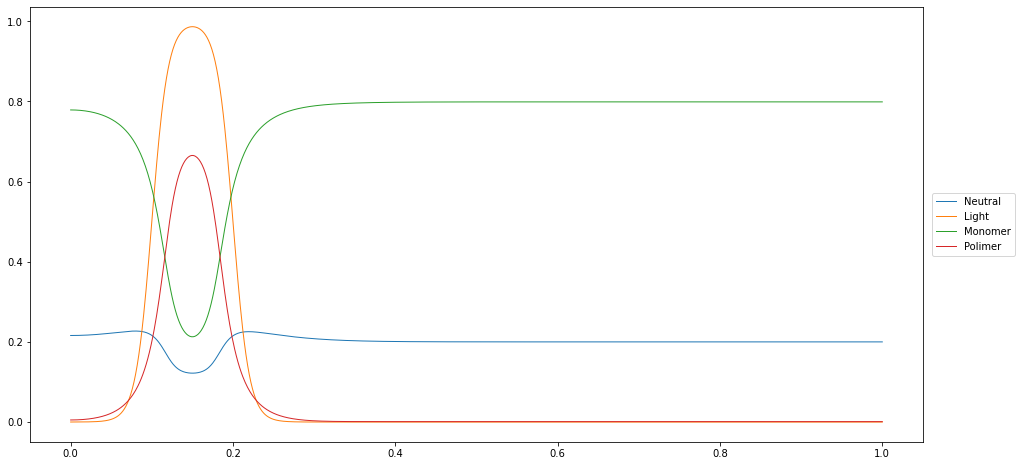

In [35]:
solve(
    # save=True,
    # n_steps=2000,
    reset=True,
)
draw()

Rule: Right - left


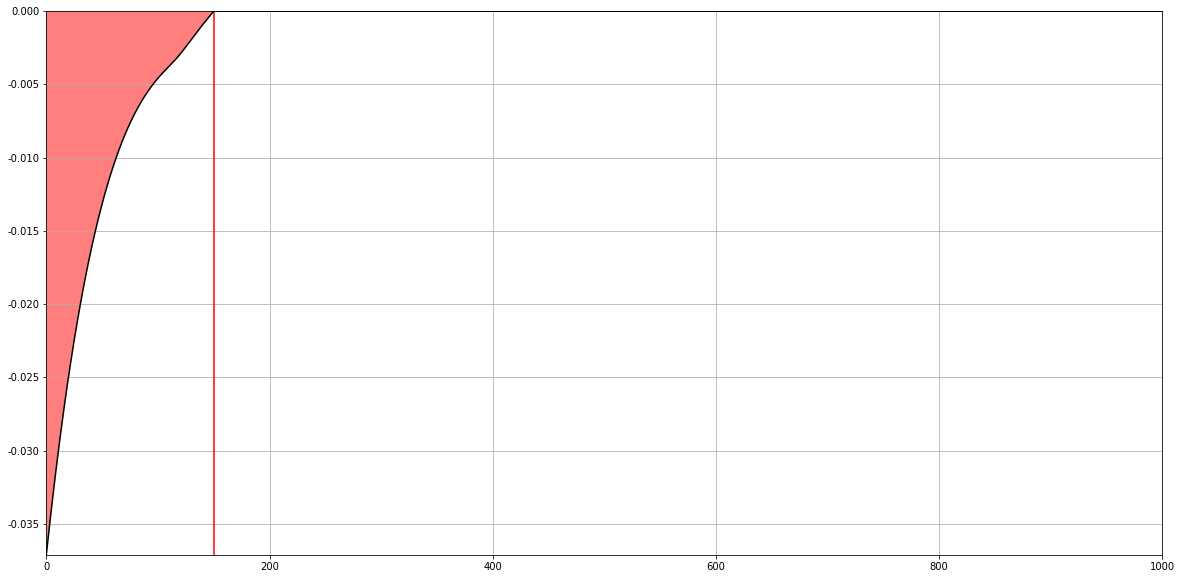

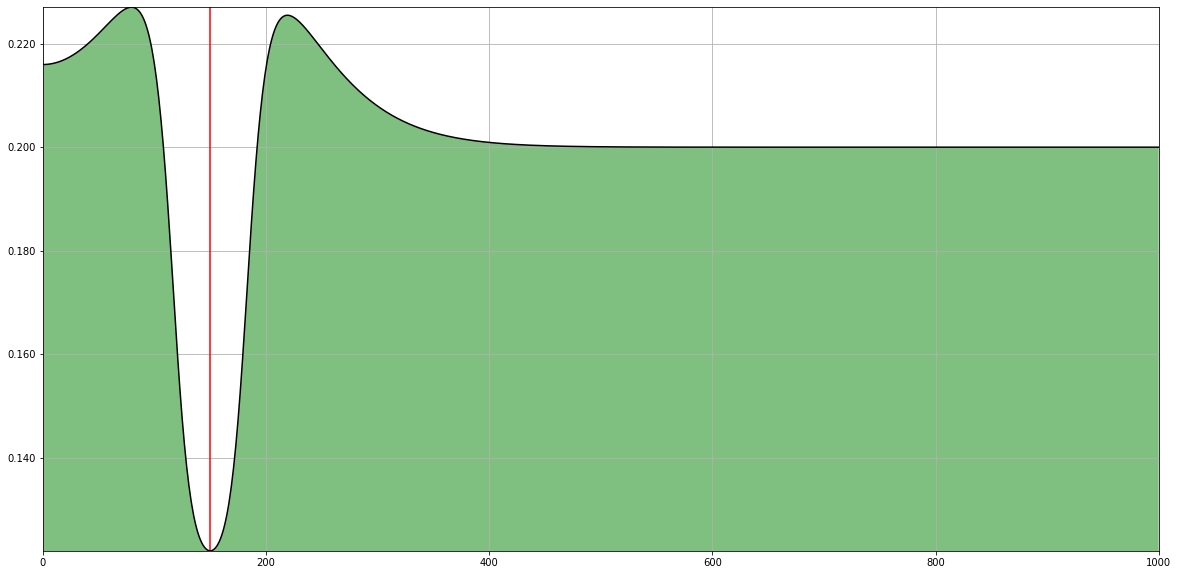

In [36]:
check_symmetry(add_point=0, func= Function(SUBSPACE.N, SUB_FUNC.N, 'neutral'))